# Dog breeds identification

This notebook is a simple solution for the dog breeds identification kaagle <a href="https://www.kaggle.com/c/dog-breed-identification">competition</a>.
I used VGG16 pretrained weights for features detection then adding to it 2 trainables dense layers  so it would match our problem.

## librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import cv2 as cv
import os
import tensorflow as tf

%matplotlib inline

## Loading and exploring the data

In [2]:
labels = pd.read_csv('labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
id       10222 non-null object
breed    10222 non-null object
dtypes: object(2)
memory usage: 159.8+ KB


In [4]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
names = list(labels['id'])
breeds = list(labels['breed'])

In [6]:
## function to open image using its name and path
def open_image(name, path):
    image = cv.imread(path+name+'.jpg')
    image = cv.cvtColor(image,cv.COLOR_BGR2RGB) ## convert it to RGB because cv2 open images as BGR
    return image

In [7]:
l=len(names) # number of samples
path='train/' # path of the samples images

In [8]:
## function that show 6 random images from the training set
def show_samples():
    indexes = np.random.randint(l,size=6)
    names_to_show = [names[i] for i in list(indexes)]
    
    fig , axs = plt.subplots(2, 3, figsize=(13,13))
    for i in range(6):
        image = open_image(names_to_show[i],path)
        label = breeds[indexes[i]]
        axs[i//3,i%3].set_title(label)
        axs[i//3,i%3].imshow(image)

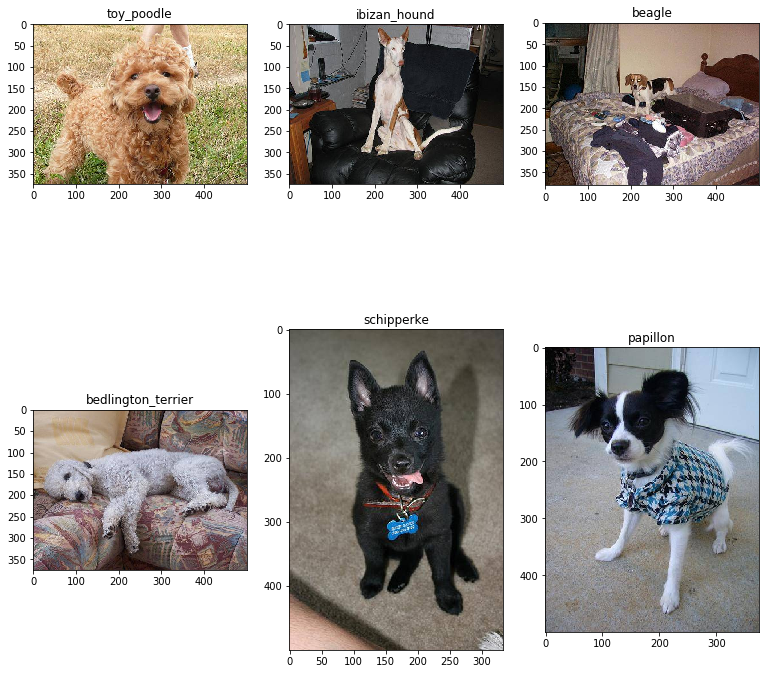

In [9]:
#examples
show_samples()

## saving breeds in different folders to be able to work with image data generator 

In [10]:
train_path='train_images/' # path where to store training set 
valid_path='valid_images/' # path where to store validation set

In [11]:
# create folders
#for breed in list(set(breeds)):
#    os.makedirs(train_path+breed)
#    os.makedirs(valid_path+breed)

In [12]:
perm = np.random.permutation(l) # to shuffle the dataset
train_size = int(l*(0.85)) ## training set size
valid_size = l-train_size ## validation set size
train_indexes = perm[:train_size] ## indexes for training set
valid_indexes = perm[train_size:] ## indexes for validation set

In [13]:
# save the images in their corresponding folders
def save_images_into_folder():
    for i in train_indexes:
        image = cv.imread('train/'+names[i]+'.jpg')
        cv.imwrite(train_path+breeds[i]+'/'+names[i]+'.jpg',image)
    for i in valid_indexes:
        image = cv.imread('train/'+names[i]+'.jpg')
        cv.imwrite(valid_path+breeds[i]+'/'+names[i]+'.jpg',image)

In [14]:
#save_images_into_folder() ## we need to apply this only one time to save the images in the disk

In [15]:
enum = list(enumerate(list(set(breeds)))) ## generate list of pairs so we can create mapping between breeds and range[0,119]

In [16]:
val_to_breed = {item[0]:item[1] for item in enum} ## map index to breed
breed_to_val ={item[1]:item[0]for item in enum} ## map breed to index

## Creating the model

In [17]:
# model librairies
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from keras.applications.vgg16 import VGG16
from keras.models import Input
from keras.layers import Dense
from keras.models import Model
from keras.layers import Flatten
from keras.models import model_from_json
from keras import Sequential

Using TensorFlow backend.


In [18]:
new_input = Input(shape=(128, 128, 3)) # define new input shape

model = VGG16(include_top = False ,input_tensor=new_input) # load VGG16 model

for layer in model.layers:
    layer.trainable = False #  make layers of VGG as non trainable 

flat1 = Flatten()(model.outputs[0])  ## flatten the ouput of the VGG16 model
dense1 = Dense(1024, activation='relu')(flat1) ## dense layer
outputs = Dense(120, activation='softmax')(dense1) ## output layer
my_model = Model(inputs = model.inputs, outputs= outputs) ## define the model
my_model.compile(
            loss="categorical_crossentropy",
            optimizer='adam',
            metrics=['accuracy'])


In [19]:
nb_epochs = 5 ## number of epochs
batch_size = 32 ## batch size

In [20]:
my_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [21]:
# define the train and validation data generators
train_datagen = ImageDataGenerator(
        rescale=1./255, ## to normalize the images
        shear_range=0.2, 
        zoom_range=0.2,
        horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode="categorical")
validation_generator = valid_datagen.flow_from_directory(
        valid_path,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode="categorical")

Found 8688 images belonging to 120 classes.
Found 1534 images belonging to 120 classes.


In [ ]:
my_model.fit_generator(
        train_generator,
        steps_per_epoch=250,
        epochs=nb_epochs,
        validation_data=validation_generator,
        validation_steps=50)

## Save and load the model

In [ ]:
#to save the model
model_json = my_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
my_model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
# load the trained model which will be in the file 
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

## Predictions

In [ ]:
#funtion to predict the ouput of image given it's name and path
def predict_probas(name,path):
    image = tf.keras.preprocessing.image.load_img(path+name+'.jpg', target_size=(128,128), interpolation='bilinear')
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr]) 
    input_arr/=255
    predictions = loaded_model.predict(input_arr)
    return predictions

In [ ]:
to_pred_ids = [] ## to store the ids of the test set
predictions = [] ## to store the results of the test set

In [ ]:
import glob
for filename in glob.glob('test/*.jpg'):
    to_pred_ids.append(filename[5:-4])
    predictions.append(predict_probas(filename[5:-4],'test/'))

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv') ## read the sample submission to 

In [ ]:
sample_submission.head()

In [ ]:
cols = sample_submission.columns ## to get the exact order of the columns
print(cols)

In [ ]:
submission = pd.DataFrame() ## the submission dataframe

In [ ]:
submission['id']=to_pred_ids ## set the ids 

In [ ]:
predictions = np.array(predictions)

In [ ]:
predictions = predictions.reshape((-1,120))

In [ ]:
# set the values for the other columns
for i in range(1,len(cols)):
    colname = cols[i];
    ind = breed_to_val[colname]
    submission[colname]=predictions[:,ind]

In [ ]:
submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False) ## save the submission into csv without the index as wanted